# 1. 先用預訓練好的神經網路提取影片特徵

In [2]:
import cv2
import os
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

In [3]:
import tensorflow as tf
# 设置 TensorFlow 使用 GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# VGG16 model，只做到特徵提取
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

In [5]:
# Load dataset
dataset_dir = './dataset'

dataset = []
for category in os.listdir(dataset_dir):
    shape = (1, len(os.listdir(os.path.join(dataset_dir, category))))
    print(shape)
    # shuffle = np.ones(shape)
    # shuffle[0, np.random.choice(shape[1], size=shape[1]//2, replace=False)] = 0

    video_count = 0 # 計算這個類別有幾個影片
    category_path = os.path.join(dataset_dir, category)
    for index, video in enumerate(os.listdir(category_path)):
        video_path = os.path.join(category_path, video)
        if not os.path.isdir(video_path):
            continue
        # if shuffle[0, index] == 0:
        #     continue

        frames = []
        cnt = -1
        for frame in os.listdir(video_path):
            cnt += 1
            # if cnt % 3 != 0:
            #     continue
            frame_path = os.path.join(video_path, frame)
            img = cv2.imread(frame_path)
            img = img / 255.0
            img = np.expand_dims(img, axis=0)  # 拓展維度
            img = preprocess_input(img)  # 預處理
            frames.append(img)

        dataset.append(frames)


(1, 39)
(1, 36)
(1, 33)
(1, 36)
(1, 44)
(1, 46)


In [6]:
# 提取特徵
print(len(dataset))
dataset = np.array(dataset)
print(dataset.shape)

videos_features = []
for data in dataset:
    features = []
    for frame in data:
        print(frame.shape)
        feature = model.predict(frame)
        features.append(feature)
    videos_features.append(np.concatenate(features, axis=0))
    print(len(videos_features))


234
(234, 30, 1, 90, 160, 3)
(1, 90, 160, 3)
1/1 [==============================] - 9s 9s/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 34ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 18ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 17ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 17ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 19ms/step
(1, 90, 160, 3)
1/1 [

In [12]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
data = np.array(videos_features)
X = data.reshape((data.shape[0], -1))
print(X.shape)


print(X)

(234, 768000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
# pca = PCA(n_components=1000)
# X = pca.fit_transform(X)
# print(X.shape)

ValueError: n_components=1000 must be between 0 and min(n_samples, n_features)=234 with svd_solver='full'

In [10]:
kmeans = KMeans(n_clusters=36)
kmeans.fit(X)
Y = kmeans.labels_

c:\ProgramData\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(234, 2)


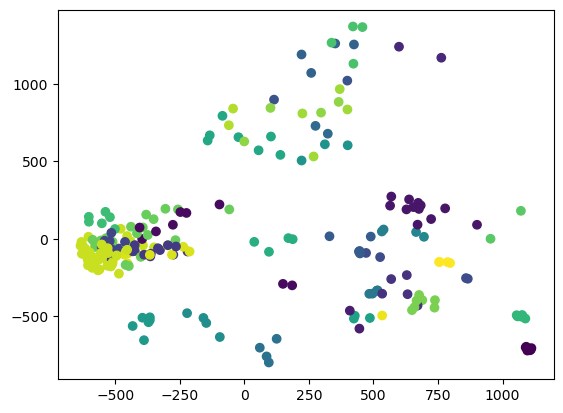

In [11]:
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)
print(pca_X.shape)

plt.scatter(pca_X[:, 0], pca_X[:, 1], c=Y)

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('result/k-means/output.png')

In [14]:
def retrieve_info(cluster_labels, y_train):
    # Initializing
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(Y))):
        index = np.where(cluster_labels == i)[0]  # 获取簇 i 的索引
        if len(index) > 0:
            num = np.bincount(y_train[index]).argmax()  # 计算簇 i 中标签的众数
            reference_labels[i] = num
        else:
            reference_labels[i] = -1  # 处理簇中没有样本的情况
    return reference_labels

In [16]:
y_test = [0]*39 + [1]*36 + [2]*33 + [3]*36 + [4]*44 + [5]*46
y_test = np.array(y_test)
reference_labels = retrieve_info(Y, y_test)
number_labels = np.random.rand(len(Y))
for i in range(len(Y)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

accuracy score: 0.47435897435897434 

[[16  5  1  0  0 17]
 [ 6 20  0  8  0  2]
 [10  7  5  2  0  9]
 [ 4  8  0 24  0  0]
 [ 4  8  0  6 24  2]
 [ 6  6  5  2  5 22]]
Confusion matrix, without normalization
[[16  5  1  0  0 17]
 [ 6 20  0  8  0  2]
 [10  7  5  2  0  9]
 [ 4  8  0 24  0  0]
 [ 4  8  0  6 24  2]
 [ 6  6  5  2  5 22]]


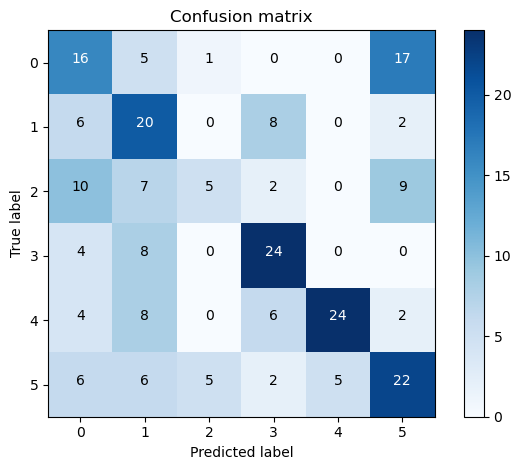

In [20]:
# print(number_labels)

cnf_matrix_sklearn = confusion_matrix(y_test, number_labels)
acc = accuracy_score(y_test, number_labels)
print("accuracy score:", acc, '\n')
print(cnf_matrix_sklearn)
plot_confusion_matrix(cnf_matrix_sklearn, [0, 1, 2, 3, 4, 5], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)